<function matplotlib.pyplot.show(close=None, block=None)>

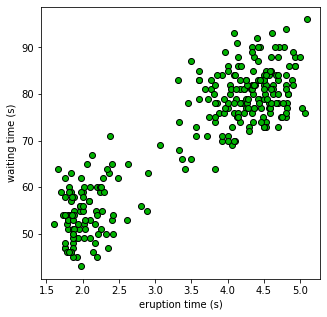

In [4]:
# Tool for a didactic introduction to the EM algorithm
# Author: Sascha Lill
# Date:   Dec 31 2020

# load libraries, visualize the data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("faithful.csv")     #'faithful.csv' ONLY
#df = pd.read_csv("iris.csv")        #'iris.csv' ONLY
X = df.to_numpy()
#X = X[:,0:3]                        #'iris.csv' ONLY
X = X.astype(np.float64)

plt.figure(figsize=(5, 5))
plt.scatter(X[:,0],X[:,1], color = (0,0.7,0), edgecolors = 'k')
plt.xlabel('eruption time (s)')
plt.ylabel('waiting time (s)')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

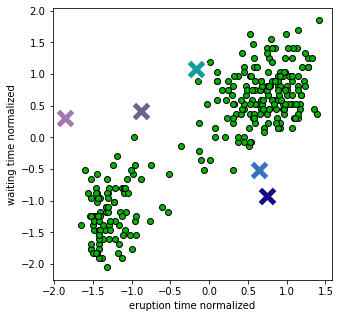

In [7]:
# normalize the data
X_mean = np.mean(X, axis=0)         # mean of columns
X_std  = np.std(X, axis=0)          # standard deviation of columns
X = X - X_mean
X = X/X_std

# initialize the EM algorithm
maxiter = 1000                      # maximum iteration number
eps = 10**(-3)                      # tolerance for change of J
iter = 1                            # iteration number

N = np.shape(X)[0]                  # N = number of rows in the data set
K = 5                               # K = cluster number
D = np.shape(X)[1]                  # D = number of columns in the data set (Dimension)
rand_col = 0.8*np.random.rand(K,3)  # random coloring

#mu = np.array([[1,-1],[-1,1]])     # (K,D) initial guess for means
mu    = np.random.normal(size=(K,D))# (K,D) initial guess for means
sigma = np.array([np.eye(D),]*K)    # (K,D,D) initial guess for covariance
pi    = np.array([1/K,]*K)          # (K) initial guess for weights


# distance evaluation
#dist_vect = np.swapaxes(np.array([X,]*K),0,1)  - np.array([mu,]*N) # (N,K,D) distance vectors of point n to mean k
#dist_scal = np.linalg.norm(dist_vect, axis = 2)                    # (N,K) distance scalars of point n to mean k


plt.figure(figsize=(5, 5))
plt.scatter(X[:,0],X[:,1], color = (0,0.7,0), edgecolors = 'k')
plt.scatter(mu[0,0],mu[0,1], color = 'w', marker = 'x', s = 300, linewidth=8)
plt.scatter(mu[0,0],mu[0,1], color = 'r', marker = 'x', s = 200, linewidth=5)

if (K == 2):
    plt.scatter(mu[1,0],mu[1,1], color = 'w', marker = 'x', s = 300, linewidth=8)
    plt.scatter(mu[1,0],mu[1,1], color = 'b', marker = 'x', s = 200, linewidth=5)

#colorful plots for more than 2 clusters
if (K > 2):
    for k in range(K):
        plt.scatter(mu[k,0],mu[k,1], color = 'w', marker = 'x', s = 300, linewidth=8)
        plt.scatter(mu[k,0],mu[k,1], color = rand_col[k,:], marker = 'x', s = 200, linewidth=5)



plt.xlabel('eruption time normalized')
plt.ylabel('waiting time normalized')


plt.savefig('EM1.png')
plt.show

covariances:

[0.03065087 0.48286836]
[0.04737059 0.49050058]
[0.09510637 0.18023316]
[0.04686082 0.43366301]
[0.03363477 0.18825313]

Log-Likelihood:  223.78767676710652


<function matplotlib.pyplot.show(close=None, block=None)>

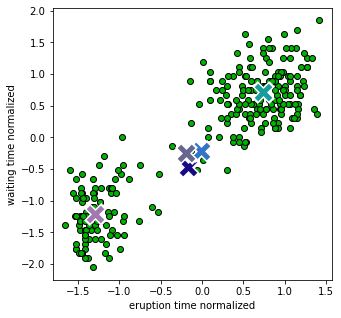

In [16]:
#gaussian distribution for K gaussians
def gauss(x_n,mu_k,sigma_k,D):
    det = np.linalg.det(sigma_k)
    if (det < 10**(-12)):
        sigma_k += 10**(-1)*np.eye(D)                   #avoid singular matrices
        det = np.linalg.det(sigma_k)
    sigma_inverse = np.linalg.inv(sigma_k)
    exponent = -0.5*np.dot((x_n-mu_k),np.tensordot(sigma_inverse, (x_n-mu_k),axes = (1,0)))
    gauss = np.power(2*np.pi*det, -D/2)*np.exp(exponent)
    return(gauss)
    

# E-step
gamma = np.zeros((N,K))                                                # (N,K) weight matrix (posterior distribution)
for n in range(N):
    for k in range(K):
        gamma[n,k] = pi[k]*gauss(X[n,:],mu[k,:],sigma[k,:,:],D)
    gamma[n,:] = gamma[n,:] / np.sum(gamma[n,:])
        

# M-step
N_k = np.sum(gamma,axis=0)                                         # (K) "cluster size"
N_k1 = np.maximum(N_k,0.00001)                                     # (K) avoid division by 0
gamma_normal = gamma / np.array([N_k,]*N)                          # (N,K) weight matrix, normalized
weight_tensor = np.swapaxes(np.array([gamma_normal,]*D),0,2)       # (K,N,D) weights of all coordinates

pi = N_k/N                                                         # (K)     new cluster size shares
mu = np.sum(X*weight_tensor, axis = 1)                             # (K,D)   new means
# sigma is a (K,D,D)-tensor. A (K,N,D,D)-tensor would be needed, to compute it.
# We do the computation step-wise to aviod running out of memory.
print('covariances:\n')
sigma = np.zeros((K,D,D))                                          # (K,D,D) new covariance
for k in range(K):
    for n in range(N):
        x_mu = X[n,:] - mu[k,:]                                    # (D) difference vector
        sigma[k,:,:] += gamma_normal[n,k]*np.tensordot(x_mu,x_mu,axes = 0) # (D,D) covariance matrix
    print(np.linalg.eig(sigma[k,:,:])[0])                                                                   


# log-likelihood evaluation
L = 0
for n in range(N):
    l = 10**(-10)
    for k in range(K):
        l += pi[k]*gauss(X[n,:],mu[k,:],sigma[k,:,:],D)
    L += np.log(l)

print('\nLog-Likelihood: ',L)



plt.figure(figsize=(5, 5))
plt.scatter(X[:,0],X[:,1], color = (0,0.7,0), edgecolors = 'k')
plt.scatter(mu[0,0],mu[0,1], color = 'w', marker = 'x', s = 300, linewidth=8)
plt.scatter(mu[0,0],mu[0,1], color = 'r', marker = 'x', s = 200, linewidth=5)

if (K == 2):
    plt.scatter(mu[1,0],mu[1,1], color = 'w', marker = 'x', s = 300, linewidth=8)
    plt.scatter(mu[1,0],mu[1,1], color = 'b', marker = 'x', s = 200, linewidth=5)

#colorful plots for more than 2 clusters
if (K > 2):
    for k in range(K):
        plt.scatter(mu[k,0],mu[k,1], color = 'w', marker = 'x', s = 300, linewidth=8)
        plt.scatter(mu[k,0],mu[k,1], color = rand_col[k,:], marker = 'x', s = 200, linewidth=5)

plt.xlabel('eruption time normalized')
plt.ylabel('waiting time normalized')

plt.show

In [19]:
# Area for testing code - and safety margin

#a = np.swapaxes(np.array([[0,1],[1,0],[1,1]]),0,1)
#b = np.array([2,2])

#print(np.linalg.norm(b) )

covariances (eigenvalues of sigma):
 [[2.08278165e-02 6.15292665e-02]
 [2.52257860e-02 6.47292324e-02]
 [2.38419011e-03 6.12783018e-01]
 [1.75419997e+00 6.83159178e-05]
 [4.08991781e-03 3.23652482e-01]
 [8.50156090e-04 1.51830311e+00]
 [2.84439100e-01 5.00227858e-03]
 [1.65851257e-02 9.66024838e-02]
 [2.31031384e-02 6.49458414e-02]
 [1.71508099e-02 9.93051918e-02]]


<function matplotlib.pyplot.show(close=None, block=None)>

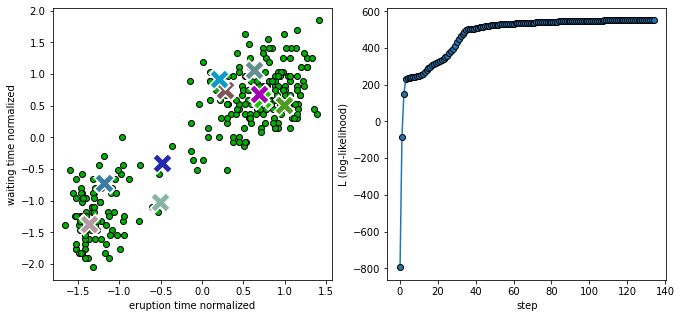

In [21]:
#The complete EM algorithm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

K = 10                               # K = cluster number
maxiter = 1000                      # maximum iteration number
epsilon = 10**(-3)                  # tolerance for change of J
iter = 1                            # iteration number
Delta_L = epsilon + 1               # change of J, is initially larger than epsilon

def normalize(X):
    X_mean = np.mean(X, axis= 0)    # mean of columns
    X_std  = np.std(X,axis = 0)     # standard deviation of columns
    X = X - X_mean
    X = X/X_std
    return(X)

#gaussian distribution for K gaussians
def gauss(x_n,mu_k,sigma_k,D):
    det = np.linalg.det(sigma_k)
    if (det < 10**(-12)):
        sigma_k += 10**(-1)*np.eye(D)                   #avoid singular matrices
        det = np.linalg.det(sigma_k)
    sigma_inverse = np.linalg.inv(sigma_k)
    exponent = -0.5*np.dot((x_n-mu_k),np.tensordot(sigma_inverse, (x_n-mu_k),axes = (1,0)))
    gauss = np.power(2*np.pi*det, -D/2)*np.exp(exponent)
    return(gauss)

#log-likelihood evaluation
def logeval(N,K,D,X,mu,sigma,pi):
    L = 0
    for n in range(N):
        l = 10**(-10)
        for k in range(K):
            l += pi[k]*gauss(X[n,:],mu[k,:],sigma[k,:,:],D)
        L += np.log(l)
    return(L)
    
    
def EM_initialize(X):
    N = np.shape(X)[0]                                                 # N = number of rows in the data set
    D = np.shape(X)[1]                                                 # D = number of columns in the data set (Dimension)
    rand_col = 0.8*np.random.rand(K,3)                                 # random coloring

    #mu = np.array([[1,-1],[-1,1]])                                    # (K,D) initial guess for means
    mu    = np.random.normal(size=(K,D))                               # (K,D) initial guess for means
    sigma = np.array([np.eye(D),]*K)                                   # (K,D,D) initial guess for covariance
    pi    = np.array([1/K,]*K)                                         # (K) initial guess for weights
    L = np.array([])                                                   # log-likelihood vector
    L = np.append(L,logeval(N,K,D,X,mu,sigma,pi))                         # Log-likelihood evaluation
    return(X,N,D,mu,sigma,pi,L)


def EM_step(X,N,D,mu,sigma,pi,L):
    # E-step
    gamma = np.zeros((N,K))                                            # (N,K) weight matrix (posterior distribution)
    for n in range(N):
        for k in range(K):
            gamma[n,k] = pi[k]*gauss(X[n,:],mu[k,:],sigma[k,:,:],D)
        gamma[n,:] = gamma[n,:] / np.sum(gamma[n,:])

    # M-step
    N_k = np.sum(gamma,axis=0)                                         # (K) "cluster size"
    N_k1 = np.maximum(N_k,0.00001)                                     # (K) avoid division by 0
    gamma_normal = gamma / np.array([N_k,]*N)                          # (N,K) weight matrix, normalized
    weight_tensor = np.swapaxes(np.array([gamma_normal,]*D),0,2)       # (K,N,D) weights of all coordinates

    pi = N_k/N                                                         # (K)     new cluster size shares
    mu = np.sum(X*weight_tensor, axis = 1)                             # (K,D)   new means
    # sigma is a (K,D,D)-tensor. A (K,N,D,D)-tensor would be needed, to compute it.
    # We do the computation step-wise to aviod running out of memory.
    sigma = np.zeros((K,D,D))                                          # (K,D,D) new covariance
    for k in range(K):
        for n in range(N):
            x_mu = X[n,:] - mu[k,:]                                    # (D) difference vector
            sigma[k,:,:] += gamma_normal[n,k]*np.tensordot(x_mu,x_mu,axes = 0) # (D,D) covariance matrix

    L = np.append(L,logeval(N,K,D,X,mu,sigma,pi))                         # Log-likelihood evaluation
    return(X,N,D,mu,sigma,pi,L)



#MAIN function
df = pd.read_csv("faithful.csv")
#df = pd.read_csv("iris.csv")
X = df.to_numpy()
#X = X[:,0:3]                        #this is required for processing 'iris.csv'
X = X.astype(np.float64)

X = normalize(X)

(X,N,D,mu,sigma,pi,L) = EM_initialize(X)

while (Delta_L > epsilon) and (iter < maxiter):
    (X,N,D,mu,sigma,pi,L) = EM_step(X,N,D,mu,sigma,pi,L)
    Delta_L = L[-1] - L[-2]
    iter += 1

print('covariances (eigenvalues of sigma):\n',np.linalg.eig(sigma)[0])
    
    
    
#Plotting the results
fig,ax = plt.subplots(1,2,figsize=(11,5))
ax[0].scatter(X[:,0],X[:,1], color = (0,0.7,0), edgecolor = 'k')                             # green only
ax[0].scatter(mu[0,0],mu[0,1], color = 'w', marker = 'x', s = 300, linewidth=8)
ax[0].scatter(mu[0,0],mu[0,1], color = 'r', marker = 'x', s = 200, linewidth=5)
if (K == 2):
    ax[0].scatter(mu[1,0],mu[1,1], color = 'w', marker = 'x', s = 300, linewidth=8)
    ax[0].scatter(mu[1,0],mu[1,1], color = 'b', marker = 'x', s = 200, linewidth=5)

#colorful plots for more than 2 clusters
if (K > 2):
    for k in range(K):
        rand_col = 0.8*np.random.rand(3)
        ax[0].scatter(mu[k,0],mu[k,1], color = 'w', marker = 'x', s = 300, linewidth=8)
        ax[0].scatter(mu[k,0],mu[k,1], color = rand_col, marker = 'x', s = 200, linewidth=5)

ax[0].set_xlabel('eruption time normalized')
ax[0].set_ylabel('waiting time normalized')
#ax[1].plot(np.arange(np.size(J)),[J[-1],]*np.size(J), color = (0.5,0.5,0.5))
ax[1].plot(np.arange(np.size(L)),L, marker = 'o', mec = 'k')
ax[1].set_xlabel('step')
ax[1].set_ylabel('L (log-likelihood)')
#ax[1].set_ylim(ymin = 0)

plt.show